#Part 4 BERT for arithmetic sentiment analysis

Acknowledgement: We used most of the code from https://mccormickml.com/2019/07/22/BERT-fine-tuning/ 

Most Credit to: 
Chris McCormick and Nick Ryan

# Bert Background


**B**idirectional **E**ncoder **R**epresentations from
**T**ransformers (BERT) [Devlin  et  al.,  2019], as the name suggests, is a language model based on the Transformer  [Vaswani et al., 2017] encoder architecture that has been pre-trained on a large dataset of unlabeled sentences from Wikipedia and BookCorpus [Zhu et al., 2015]. Given a sequence of tokens representing sentence(s), BERT outputs a ``contextualized representation" vector for each of the token. Now, suppose we are given some down-stream tasks, such as sentence classification or question-answering. We can take the BERT model, add a small layer on top of the BERT representation(s), and then fine-tune the added parameters **and** BERT parameters on the down-stream dataset, which is typically much smaller than the data used to pre-train BERT. 

In traditional language modeling task, the objective is to maximize the log likelihood of predicting the current word (or token) in the sentence, given the previous words (to the left of current work) as context. This is called the *autoregressive model*. In BERT, however, we wish to predict the current word given both the words before and after (i.e. to the left and to the right) of the sentence--hence *bidirectional*.
To be able to attend from both directions, BERT uses the encoder Transformer, which does not apply any attention masking unlike the decoder.

We briefly describe how BERT is pre-trained. BERT has 2 task objectives for pre-training: (1) *Masked Language Modeling* (Masked LM), and (2) *Next Sentence Prediction*(NSP). The input to the model is a sequence of tokens of the form:
```
    [CLS] Sentence A [SEP] Sentence B,
```
where `[CLS]`  ("class") and `[SEP]` ("separator") are special tokens. 
In Masked LM, some percentage of the input tokens are converted into `[MASK]` tokens, and the objective is to use the final layer representation for that masked token to predict the correct word that was masked out. For NSP, the task is to use the contextualized representation for the `[CLS]` token to perform binary classification for whether sentence A and sentence B are consecutive sentences in the unlabeled dataset. See Figure 6 (in Handout) for the conceptual picture of BERT pre-training and fine-tuning. 

In this assignment, you will be **fine-tuning BERT on a single sentence classification task** (see below about the dataset). Figure 7 (in Handout) illustrates the architecture for fine-tuning on this task. We prepend the tokenized sentence with the `[CLS]` token, then feed the sequence into BERT. We then take the contextualized `[CLS]` token representation at the last layer of BERT and add either a softmax layer on top corresponding to the number of output classes in the task. Alternatively, we can have fully connected hidden layers before the softmax layer for more expressivity for harder tasks. Then, both the new layers and the entire BERT parameters are trained end to end on the task for a few epochs. 


# 1. Setup 

## Install transformers repo that has Bert


In [0]:
!pip install transformers

## Download & Extract
Run the following cells to downlaod the dataset files from the CSC413 webpage.

<!-- Download the two csv dataset files from CSC413 webpage, click the folder icon,  -->
<!-- and click "upload" to upload them.  -->

<!-- https://csc413-2020.github.io/assets/misc/PA03_data_20_train.csv 

https://csc413-2020.github.io/assets/misc/PA03_data_20_test.csv   -->

In [0]:
!pip install wget

In [3]:
import wget
import os

print('Downloading verbal arithmetic dataset')

# The URL for the dataset zip file.
url = 'https://csc413-2020.github.io/assets/misc/'

# Download the file (if we haven't already)
if not os.path.exists('./PA03_data_20_train.csv'):
  wget.download(url + 'PA03_data_20_train.csv', './PA03_data_20_train.csv')
  print('Done downloading training data')
else:
  print('Already downloaded training data')

if not os.path.exists('./PA03_data_20_test.csv'):
  wget.download(url + 'PA03_data_20_test.csv', './PA03_data_20_test.csv')
  print('Done downloading test data')
else:
  print('Already downloaded test data')

Done downloading training data
Done downloading test data



##  Load Training Data

In [5]:
import pandas as pd

df = pd.read_csv("./PA03_data_20_train.csv", header=0, names=["index", "input", "label"])

print("Number of data points: ", df.shape[0])
sampled = df.sample(10)
# Display 10 random rows from the data.
df.sample(10)

Number of data points:  640


,index,input,label
119,539,six minus nineteen,0
305,286,fourteen plus six,2
530,484,four minus four,1
216,600,ten minus zero,2
206,154,seven plus fourteen,2
507,517,five minus seventeen,0
328,423,one minus three,0
619,152,seven plus twelve,2
395,29,one plus nine,2
383,735,sixteen minus fifteen,2


The two properties we actually care about are the the `inputs` and its `label`, which are the questions and the answers.  

**label=0** means the result of expression is **negative**

**label=1** means the result of expression is **zero**

**label=2** means the result of expression is **positive** 

## BERT Tokenizer


To feed our text to BERT, it must be split into tokens, and then these tokens must be mapped to their index in the tokenizer vocabulary.



In [6]:
from transformers import BertTokenizer

# Load the BERT tokenizer.
print('Loading BERT tokenizer...')
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

Loading BERT tokenizer...


In [7]:
inputs = df.input.values
labels = df.label.values
print("Train data size ", len(inputs))
print(' Original: ', inputs[0])
# Print the sentence split into tokens.
print('Tokenized: ', tokenizer.tokenize(inputs[0]))
# Print the sentence mapped to token ids.
print('Token IDs: ', tokenizer.convert_tokens_to_ids(tokenizer.tokenize(inputs[0])))

Train data size  640
 Original:  five minus twelve
Tokenized:  ['five', 'minus', 'twelve']
Token IDs:  [2274, 15718, 4376]


We can actually use the `tokenize.encode` function to handle both steps, rather than calling `tokenize` and `convert_tokens_to_ids` separately. 


## BERT Required Formatting

In a deep learning based NLP pipeline, most of the following preprocessing tricks are frequently needed regardless of whether we use BERT or RNN.
1. Add special tokens to the start and end of each sentence.
2. Pad & truncate all sentences to a single constant length.
3. Explicitly differentiate real tokens from padding tokens with the "attention mask".



### Special Tokens



**`[SEP]`**

At the end of every sentence, we need to append the special `[SEP]` token. 

This token is an artifact of two-sentence tasks, where BERT is given two separate sentences and asked to determine something (e.g., can the answer to the question in sentence A be found in sentence B?). 


**`[CLS]`**

For classification tasks, we must prepend the special `[CLS]` token to the beginning of every sentence.

This token has special significance. BERT consists of 12 Transformer layers. Each transformer takes in a list of token embeddings, and produces the same number of embeddings on the output.

On the output of the final transformer, *only the first embedding (corresponding to the [CLS] token) is used by the classifier*.

>  "The first token of every sequence is always a special classification token (`[CLS]`). The final hidden state
corresponding to this token is used as the aggregate sequence representation for classification
tasks." (from the [BERT paper](https://arxiv.org/pdf/1810.04805.pdf))

Also, because BERT is trained to only use this [CLS] token for classification, we know that the model has been motivated to encode everything it needs for the classification step into that single 768-value embedding vector.



### Sentence Length & Attention Mask



The sentences in our dataset obviously have varying lengths, so how does BERT handle this?

BERT has two constraints:
1. All sentences must be padded or truncated to a single, fixed length.
2. The maximum sentence length is 512 tokens.

Padding is done with a special `[PAD]` token, which is at index 0 in the BERT vocabulary. 

The "Attention Mask" is simply an array of 1s and 0s indicating which tokens are padding and which aren't 






## Sentences to IDs

The `tokenizer.encode` function combines multiple steps for us:
1. Split the sentence into tokens.
2. Add the special `[CLS]` and `[SEP]` tokens.
3. Map the tokens to their IDs.

Oddly, this function can perform truncating for us, but doesn't handle padding. 

In [8]:
# For Verbal Arithmetic
input_ids = []

# For every sentence...
for input in inputs:
    # `encode` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    encoded_input = tokenizer.encode(
                        input,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'

                        # This function also supports truncation and conversion
                        # to pytorch tensors, but we need to do padding, so we
                        # can't use these features :( .
                        #max_length = 128,          # Truncate all sentences.
                        #return_tensors = 'pt',     # Return pytorch tensors.
                   )
    
    # Add the encoded sentence to the list.
    input_ids.append(encoded_input)

# Print sentence 0, now as a list of IDs.
print('Original: ', inputs[0])
print('Token IDs:', input_ids[0])

Original:  five minus twelve
Token IDs: [101, 2274, 15718, 4376, 102]


## Padding & Truncating

Pad and truncate our sequences so that they all have the same length, `MAX_LEN`.

First, what's the maximum sentence length in our dataset?

In [9]:
print('Max sentence length: ', max([len(sen) for sen in input_ids]))

Max sentence length:  5


Given that, let's choose MAX_LEN = 7 since our numerical expression is quite short. Then apply the padding.

In [10]:
# We'll borrow the `pad_sequences` utility function to do this.
from keras.preprocessing.sequence import pad_sequences

# Set the maximum sequence length.
MAX_LEN = 7

print('\nPadding/truncating all sentences to %d values...' % MAX_LEN)

print('\nPadding token: "{:}", ID: {:}'.format(tokenizer.pad_token, tokenizer.pad_token_id))

# Pad our input tokens with value 0.
# "post" indicates that we want to pad and truncate at the end of the sequence,
# as opposed to the beginning.
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", 
                          value=0, truncating="post", padding="post")

print('\nDone.')


Padding/truncating all sentences to 7 values...

Padding token: "[PAD]", ID: 0

Done.


Using TensorFlow backend.


## Attention Masks

The attention mask simply makes it explicit which tokens are actual words versus which are padding. 

The BERT vocabulary does not use the ID 0, so if a token ID is 0, then it's padding, and otherwise it's a real token.

In [0]:
# Create attention masks
attention_masks = []

# For each sentence...
for sent in input_ids:
    
    # Create the attention mask.
    #   - If a token ID is 0, then it's padding, set the mask to 0.
    #   - If a token ID is > 0, then it's a real token, set the mask to 1.
    att_mask = [int(token_id > 0) for token_id in sent]
    
    # Store the attention mask for this sentence.
    attention_masks.append(att_mask)

## Training & Validation Split


Divide up our training set to use 90% for training and 10% for validation.

In [12]:
# Use train_test_split to split our data into train and validation sets for
# training
from sklearn.model_selection import train_test_split

# Use 90% for training and 10% for validation.
print(input_ids)
train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(input_ids, labels, 
                                                            random_state=2018, test_size=0.1)
# Do the same for the masks.
train_masks, validation_masks, _, _ = train_test_split(attention_masks, labels,
                                             random_state=2018, test_size=0.1)
set(labels)

[[  101  2274 15718 ...   102     0     0]
 [  101  7093  4606 ...   102     0     0]
 [  101  2416  4606 ...   102     0     0]
 ...
 [  101  2809  4606 ...   102     0     0]
 [  101  2698 15718 ...   102     0     0]
 [  101  2176  4606 ...   102     0     0]]


{0, 1, 2}

## Converting to PyTorch Data Types

Our model expects PyTorch tensors rather than numpy.ndarrays, so convert all of our dataset variables.

In [0]:
import torch
train_inputs = torch.tensor(train_inputs)
validation_inputs = torch.tensor(validation_inputs)

train_labels = torch.tensor(train_labels)
validation_labels = torch.tensor(validation_labels)

train_masks = torch.tensor(train_masks)
validation_masks = torch.tensor(validation_masks)

We'll also create an iterator for our dataset using the torch DataLoader class. This helps save on memory during training because, unlike a for loop, with an iterator the entire dataset does not need to be loaded into memory.

In [0]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
batch_size = 32

# Create the DataLoader for our training set.
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# Create the DataLoader for our validation set.
validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)


# 4. Questions

## Question1 [0pts]

The pre-trained neural network here is the normal BERT model from [BertForSequenceClassification](https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#bertforsequenceclassification). The goal is to add a new classification layer to the pre-trained model. We have provided two example classes to do so.

In this part, you need to make your own  `BertCSC413_MLP` class `self.classifier` by, for example, modifying the provided examples: change the number of layers; change the number of hidden neurons; or try a different activation. 

In [0]:
from transformers import BertForSequenceClassification
import torch.nn as nn
class BertCSC413_Linear(BertForSequenceClassification):
    def __init__(self, config):
        super(BertCSC413_Linear, self).__init__(config)
        self.classifier = nn.Linear(config.hidden_size, self.config.num_labels)

class BertCSC413_MLP_Example(BertForSequenceClassification):
    def __init__(self, config):
        super(BertCSC413_MLP_Example, self).__init__(config)
        self.classifier = nn.Sequential(
            nn.Linear(config.hidden_size, config.hidden_size),
            nn.ReLU(),
            nn.Linear(config.hidden_size, self.config.num_labels)
            )

class BertCSC413_MLP(BertForSequenceClassification):
    def __init__(self, config):
        super(BertCSC413_MLP, self).__init__(config)
        # Your own classifier goes here
        self.classifier = nn.Sequential(
            nn.Linear(config.hidden_size, config.hidden_size),
            nn.Tanh(),
            nn.Linear(config.hidden_size, self.config.num_labels)
            )

## Question2 [0pts]

We instantiated two different BERT models from `BertCSC413_MLP` class, which are called `model_freeze_bert` and `model_finetune_bert` in the notebook. 

**Run** the following code to train the models, and attach the training error curves of `model_freeze_bert` and `model_finetune_bert`.  

In [0]:
from transformers import AdamW, BertConfig

model_freeze_bert = BertCSC413_MLP.from_pretrained(
    "bert-base-uncased", 
    num_labels = 3, 
    output_attentions = False, 
    output_hidden_states = False,
)

In [0]:
for name, param in model_freeze_bert.named_parameters():
	if 'classifier' not in name: # classifier layer
		param.requires_grad = False


In [0]:
model_finetune_bert = BertCSC413_MLP.from_pretrained(
    "bert-base-uncased", 
    num_labels = 3,    
    output_attentions = False, 
    output_hidden_states = False,
)

In [105]:
# Model parameters visualization
params = list(model_finetune_bert.named_parameters())

print('The BERT model has {:} different named parameters.\n'.format(len(params)))

print('==== Embedding Layer ====\n')

for p in params[0:5]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== First Transformer ====\n')

for p in params[5:21]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== Output Layer ====\n')

for p in params[-4:]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

The BERT model has 203 different named parameters.

==== Embedding Layer ====

bert.embeddings.word_embeddings.weight                  (30522, 768)
bert.embeddings.position_embeddings.weight                (512, 768)
bert.embeddings.token_type_embeddings.weight                (2, 768)
bert.embeddings.LayerNorm.weight                              (768,)
bert.embeddings.LayerNorm.bias                                (768,)

==== First Transformer ====

bert.encoder.layer.0.attention.self.query.weight          (768, 768)
bert.encoder.layer.0.attention.self.query.bias                (768,)
bert.encoder.layer.0.attention.self.key.weight            (768, 768)
bert.encoder.layer.0.attention.self.key.bias                  (768,)
bert.encoder.layer.0.attention.self.value.weight          (768, 768)
bert.encoder.layer.0.attention.self.value.bias                (768,)
bert.encoder.layer.0.attention.output.dense.weight        (768, 768)
bert.encoder.layer.0.attention.output.dense.bias              (

We use
- Batch size: 32
- Learning rate (Adam): 2e-5  
- Number of epochs: 4

In [0]:
from transformers import get_linear_schedule_with_warmup
import random
import numpy as np
import time
import datetime

seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

def format_time(elapsed):
    elapsed_rounded = int(round((elapsed)))
    return str(datetime.timedelta(seconds=elapsed_rounded))

def train_model(model):      
    optimizer = AdamW(model.parameters(),
                  lr = 2e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )
    epochs = 4
    total_steps = len(train_dataloader) * epochs
    scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, 
                                            num_training_steps = total_steps)
    loss_values = []

    for epoch_i in range(0, epochs):
        print("")
        print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
        print('Training...')
        t0 = time.time()

        total_loss = 0
        model.train()

        for step, batch in enumerate(train_dataloader):

            if step % 40 == 0 and not step == 0:
                elapsed = format_time(time.time() - t0)
                
                # Report progress.
                print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

            b_input_ids = batch[0] #.to(device)
            b_input_mask = batch[1] #.to(device)
            b_labels = batch[2] #.to(device)

            model.zero_grad()        

            # Perform a forward pass (evaluate the model on this training batch).
            # This will return the loss (rather than the model output) because we
            # have provided the `labels`.
            # The documentation for this `model` function is here: 
            # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
            outputs = model(b_input_ids, 
                        token_type_ids=None, 
                        attention_mask=b_input_mask, 
                        labels=b_labels)
            
            # The call to `model` always returns a tuple, so we need to pull the 
            # loss value out of the tuple.
            loss = outputs[0]

            # Accumulate the training loss over all of the batches so that we can
            # calculate the average loss at the end. `loss` is a Tensor containing a
            # single value; the `.item()` function just returns the Python value 
            # from the tensor.
            total_loss += loss.item()

            # Perform a backward pass to calculate the gradients.
            loss.backward()

            # Clip the norm of the gradients to 1.0.
            # This is to help prevent the "exploding gradients" problem.
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

            # Update parameters and take a step using the computed gradient.
            # The optimizer dictates the "update rule"--how the parameters are
            # modified based on their gradients, the learning rate, etc.
            optimizer.step()

            # Update the learning rate.
            scheduler.step()

        # Calculate the average loss over the training data.
        avg_train_loss = total_loss / len(train_dataloader)            
        
        # Store the loss value for plotting the learning curve.
        loss_values.append(avg_train_loss)

        print("")
        print("  Average training loss: {0:.2f}".format(avg_train_loss))
        print("  Training epcoh took: {:}".format(format_time(time.time() - t0)))
            

        print("Running Validation...")

        t0 = time.time()
        model.eval()

        eval_loss, eval_accuracy = 0, 0
        nb_eval_steps, nb_eval_examples = 0, 0

        # Evaluate data for one epoch
        for batch in validation_dataloader:
            # batch = tuple(t.to(device) for t in batch)
            batch = tuple(t for t in batch)
            b_input_ids, b_input_mask, b_labels = batch
            
            with torch.no_grad():        
                # Forward pass, calculate logit predictions.
                # This will return the logits rather than the loss because we have
                # not provided labels.
                # token_type_ids is the same as the "segment ids", which 
                # differentiates sentence 1 and 2 in 2-sentence tasks.
                outputs = model(b_input_ids, 
                                token_type_ids=None, 
                                attention_mask=b_input_mask)
            
            # Get the "logits" output by the model. The "logits" are the output
            # values prior to applying an activation function like the softmax.
            logits = outputs[0]
            # Move logits and labels to CPU
            logits = logits.detach().cpu().numpy()
            label_ids = b_labels.to('cpu').numpy()
            # Calculate the accuracy for this batch of test sentences.
            tmp_eval_accuracy = flat_accuracy(logits, label_ids)
            # Accumulate the total accuracy.
            eval_accuracy += tmp_eval_accuracy
            # Track the number of batches
            nb_eval_steps += 1

        print("  Accuracy: {0:.2f}".format(eval_accuracy/nb_eval_steps))
        print("  Validation took: {:}".format(format_time(time.time() - t0)))
    print("")
    print("Training complete!")
    return loss_values

In [118]:
freeze_bert_loss_vals = train_model(model_freeze_bert) # about 1 minute for 4 epochs using CPU


======== Epoch 1 / 4 ========
Training...

  Average training loss: 0.66
  Training epcoh took: 0:00:14
Running Validation...
  Accuracy: 0.77
  Validation took: 0:00:01

======== Epoch 2 / 4 ========
Training...

  Average training loss: 0.63
  Training epcoh took: 0:00:14
Running Validation...
  Accuracy: 0.77
  Validation took: 0:00:01

======== Epoch 3 / 4 ========
Training...

  Average training loss: 0.63
  Training epcoh took: 0:00:14
Running Validation...
  Accuracy: 0.73
  Validation took: 0:00:01

======== Epoch 4 / 4 ========
Training...

  Average training loss: 0.61
  Training epcoh took: 0:00:14
Running Validation...
  Accuracy: 0.75
  Validation took: 0:00:01

Training complete!


In [119]:
finttune_bert_loss_vals = train_model(model_finetune_bert) # about 5 minutes for 4 epochs using CPU


======== Epoch 1 / 4 ========
Training...

  Average training loss: 0.67
  Training epcoh took: 0:04:26
Running Validation...
  Accuracy: 0.73
  Validation took: 0:00:03

======== Epoch 2 / 4 ========
Training...

  Average training loss: 0.66
  Training epcoh took: 0:04:27
Running Validation...
  Accuracy: 0.73
  Validation took: 0:00:03

======== Epoch 3 / 4 ========
Training...

  Average training loss: 0.66
  Training epcoh took: 0:04:27
Running Validation...
  Accuracy: 0.73
  Validation took: 0:00:03

======== Epoch 4 / 4 ========
Training...

  Average training loss: 0.67
  Training epcoh took: 0:04:28
Running Validation...
  Accuracy: 0.73
  Validation took: 0:00:03

Training complete!


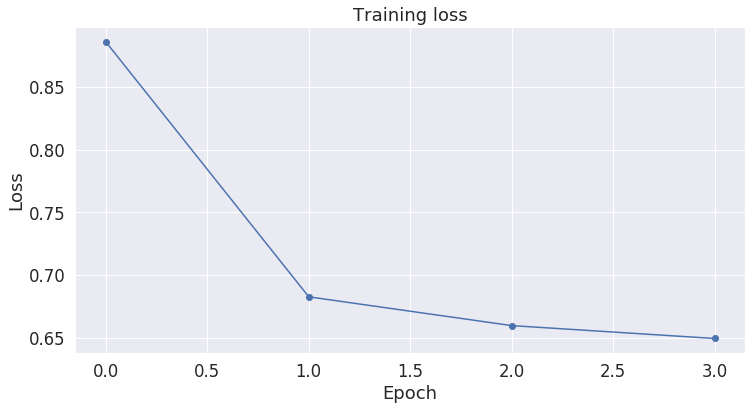

In [47]:
import matplotlib.pyplot as plt
% matplotlib inline
import seaborn as sns
def plot_loss_vals(loss_vals):
    sns.set(style='darkgrid')
    sns.set(font_scale=1.5)
    plt.rcParams["figure.figsize"] = (12,6)
    plt.plot(loss_vals, 'b-o')
    plt.title("Training loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.show()
plot_loss_vals(freeze_bert_loss_vals)

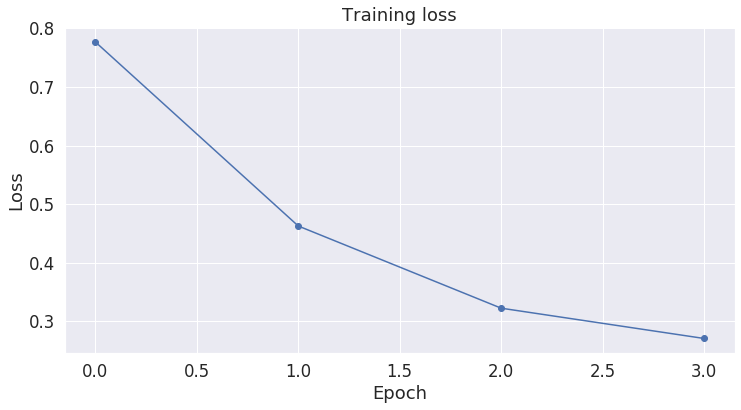

In [48]:
plot_loss_vals(finttune_bert_loss_vals)

*Run* the evaluation functions.  Report the test performances of using trained model\_freeze\_bert and model\_finetune\_bert, and briefly discuss why models are failing under certain target labels

In [49]:
import pandas as pd

# Load the dataset into a pandas dataframe.
#df = pd.read_csv("./output.txt_test.csv", delimiter='\t', header=None, names=['sentence_source', 'label', 'label_notes', 'sentence'])
df = pd.read_csv("./PA03_data_20_test.csv", header=0, names=["index", "input", "label"])

# Report the number of sentences.
print('Number of test sentences: {:,}\n'.format(df.shape[0]))

inputs = df.input.values
labels = df.label.values


# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []
input_sent = []

# For every sentence...
for arithmetic_input in inputs:
    # `encode` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    encoded_sent = tokenizer.encode(
                        arithmetic_input, 
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                   )
    input_sent.append(arithmetic_input)
    input_ids.append(encoded_sent)

# Pad our input tokens
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, 
                          dtype="long", truncating="post", padding="post")

# Create attention masks
attention_masks = []

# Create a mask of 1s for each token followed by 0s for padding
for seq in input_ids:
  seq_mask = [float(i>0) for i in seq]
  attention_masks.append(seq_mask) 

# Convert to tensors.
prediction_inputs = torch.tensor(input_ids)
prediction_masks = torch.tensor(attention_masks)
prediction_labels = torch.tensor(labels)

# Set the batch size.  
batch_size = 32  

# Create the DataLoader.
prediction_data = TensorDataset(prediction_inputs, prediction_masks, prediction_labels)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

Number of test sentences: 160



In [0]:
def eval_testdata(model_test, show_all_predictions=False):
    print('Predicting labels for {:,} test sentences...'.format(len(prediction_inputs)))

    # Put model in evaluation mode
    model_test.eval()

    # Tracking variables 
    predictions , true_labels, input_sents = [], [], []

    # Predict 
    for batch in prediction_dataloader:
        # Unpack the inputs from our dataloader
        b_input_ids, b_input_mask, b_labels = batch
        decoded_inputs = [tokenizer.decode(b_input_ids[i]).strip("[CLS] ").strip( "[SEP] ").strip(" [PAD] ").strip("[PAD]").strip(" [SE") for i in range(len(b_input_ids))]
        # Telling the model not to compute or store gradients, saving memory and 
        # speeding up prediction
        with torch.no_grad():
            # Forward pass, calculate logit predictions
            outputs = model_test(b_input_ids, token_type_ids=None, 
                            attention_mask=b_input_mask)

        logits = outputs[0]

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        input_sents.extend(decoded_inputs)
        
        # Store predictions and true labels
        predictions.extend(np.argmax(logits, axis=1))
        true_labels.extend(label_ids)
    correct = [0,0,0]
    totals = [0, 0, 0]
    for true_label, prediction in zip(true_labels, predictions):
        if true_label == prediction:
            correct[true_label] += 1
        totals[true_label] += 1
    print("Number of expressions with negative result", true_labels.count(0), "\n",  correct[0],  " predicted correctly",  ", accuracy ", correct[0]/totals[0] , "\n")
    print("Number of expressions with 0 result", true_labels.count(1), "\n",  correct[1], " predicted correctly", ", accuracy ", correct[1]/totals[1], "\n")
    print("Number of expressions with positive result", true_labels.count(2),"\n",  correct[2], " predicted correctly",", accuracy ", correct[2]/totals[2], "\n")
    if show_all_predictions:
        index_to_sentiment_map = {0:"negative", 1:"zero", 2:"positive"}
        for sent in [sent + "--> "+index_to_sentiment_map[index]  for sent, index in zip(input_sents, predictions)]:
            print(sent)

In [51]:
eval_testdata(model_freeze_bert, show_all_predictions=False)

Predicting labels for 160 test sentences...
Number of expressions with negative result 47 
 0  predicted correctly , accuracy  0.0 

Number of expressions with 0 result 2 
 0  predicted correctly , accuracy  0.0 

Number of expressions with positive result 111 
 111  predicted correctly , accuracy  1.0 



In [52]:
eval_testdata(model_finetune_bert, show_all_predictions=False)

Predicting labels for 160 test sentences...
Number of expressions with negative result 47 
 47  predicted correctly , accuracy  1.0 

Number of expressions with 0 result 2 
 0  predicted correctly , accuracy  0.0 

Number of expressions with positive result 111 
 109  predicted correctly , accuracy  0.9819819819819819 



## Question3 [1pts]

Try a few unseen examples of arithmetic questions using either model\_freeze\_bert or model\_finetune\_bert model, and find 10 interesting results.  We will give full marks as long as you provide some comments for why you chose some of the examples. The interesting results can, for example, be both successful extrapolation/interpolation results or surprising failure cases.  You can find some examples in our notebook.   

In [0]:
index_to_sentiment_map = {0:"negative", 1:"zero", 2:"positive"}
model = model_finetune_bert
def what_is(arithmetic_input):
    encoded_sent = tokenizer.encode(
                        arithmetic_input, 
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                )
    input_sent = [arithmetic_input]
    input_ids = [encoded_sent]
    input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, 
                            dtype="long", truncating="post", padding="post")
    attention_masks = []
    for seq in input_ids:
        seq_mask = [float(i>0) for i in seq]
        attention_masks.append(seq_mask) 

    with torch.no_grad():
        outputs = model(torch.tensor(input_ids), token_type_ids=None, 
                            attention_mask=torch.tensor(attention_masks))
        logits = outputs[0]
        logits = logits.detach().cpu().numpy()
        print(index_to_sentiment_map[np.argmax(logits, axis=1)[0]])

In [85]:
what_is("twelve minus fourteen")
what_is("twelve plus fourteen")
what_is("twelve minus twelve")

negative
positive
negative


In [86]:
what_is("eight plus thousand")
what_is("eight minus hundred")

positive
negative


In [87]:
what_is("1 minus 14")
what_is("1 minus two")
what_is("-1 minus two")
what_is("-1 plus 3")

negative
negative
negative
positive


In [88]:
what_is("three minus two minus eight")
what_is("three minus two plus eight")
what_is("one minus one minus one")
what_is("one minus one minus one plus ten")

negative
positive
negative
positive


In [89]:
what_is("minus one minus two")
what_is("minus 3 plus four")

negative
positive


In [90]:
what_is("eight divided by 5")
what_is("minus eight divided by 5")
what_is("3 times zero")
what_is("3 times minus six")

positive
negative
positive
negative


## Question4 [1pts]

This is an open question, and we will give marks as long as you show an attempt to try one of the following tasks.   
1. Try data augmentation tricks to improve the performances for certain target labels that models were failing to predict.  
2. Make a t-sne or PCA plot to visualize the embedding vectors of word tokens related to arithmetic expressions. 
3. Try different hyperparameter tunings. E.g. learning rates, optimizer, architecture of the classifier, training epochs, and batch size.  
4. Evaluate the Multi-class Matthews correlation score for our imbalanced test dataset.  
5. Run a baseline model using MLP without pre-trained BERT. You can assume the sequence length of all the data is 3 in this case.